In [155]:
import math
import matplotlib.pyplot as plt
import torch

In [157]:
class Value:
    def __init__(self,data, _children=(), _op='', label =''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data= {self.data})"

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data , (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self,other):
        assert isinstance(other, (int,float)), 'only supporting int and float powers'
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out 
    def __truediv__(self,other):
        return self * other**-1
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (-other)

    def __radd__(self,other):
        return self + other

    def __rmul__(self,other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out =  Value(t, (self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [161]:
a = Value(3,label = 'a')
b = Value(4, label = 'b')
c = Value(2, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2, label = 'f')
L = d*f; L.label='L'

In [164]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | gard %.4f}" % ( n.label , n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [165]:
## Manual Chain Rule Implementation
# It is multiplication of local gradient and previous gradient(with respect to L) 
# dL/dd = f.data
# dL/df = d.data

# dL/dc = (dl/dd) * (dd/dc)
#       =  -2 * 1
#       = -2

# dL/da = (dL/de) * de/da
#       =  -2 * 4
#       =  -8

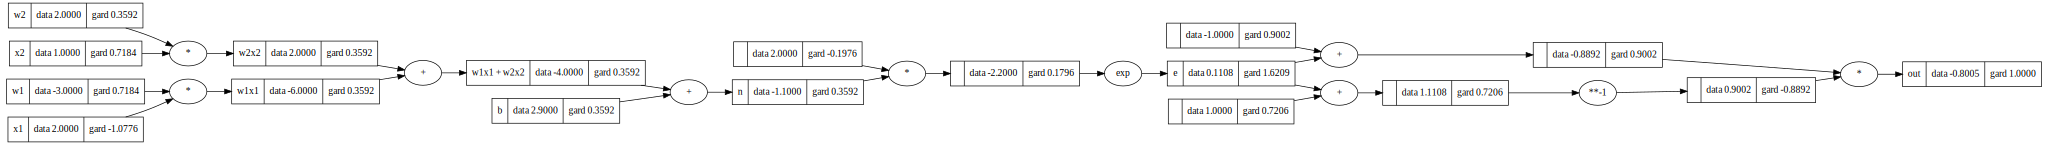

In [172]:
x1 = Value(2.0,label='x1')
x2 = Value(1.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(2.0,label='w2')
#bias
b = Value(2.9, label = 'b')
w1x1 = x1*w1; w1x1.label ='w1x1'
w2x2 = x2*w2; w2x2.label='w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label='w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'

o = (e - 1)/(e + 1); o.label = 'out'

o.backward()
draw_dot(o)

In [173]:

x1 =  torch.tensor([2]).double(); x1.requires_grad =True
x2  = torch.tensor([1]).double(); x2.requires_grad =True
w1 = torch.tensor([-3]).double(); w1.requires_grad =True
w2 = torch.tensor([2]).double(); w2.requires_grad = True
b = torch.tensor([2.9]).double(); b.requires_grad= True

n= w1*x1 + w2*x2 +b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("-----")
print('w1',w1.grad.item())
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('n',n.grad)


-0.8004989875045201
-----
w1 0.7184027420084764
x1 -1.0776041130127147
x2 0.7184027420084764
w2 0.3592013710042382
n None


/var/folders/z1/13bdlnjn41j46r3v6_st6w0c0000gn/T/ipykernel_1286/2776097840.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print('n',n.grad)


In [178]:
import random

class Neuron:
    def __init__(self,ninput):
        self.w = [Value(random.uniform(-1,1)) for _ in range(ninput)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi* xi for wi,xi in zip(self.w , x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self,ninput,nout):
        self.neurons = [Neuron(ninput) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self,ninput,nouts):
        sz = [ninput] + nouts
        self.layers = [Layer(sz[i] ,sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [361]:
n = MLP(3,[4,4,1])

In [355]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [376]:
for k in range(20):
    #forward
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data -= 0.1 * p.grad

    print(k, loss.data)

0 0.001121658152207949
1 0.001117474971956843
2 0.001113322382505856
3 0.0011092000522510016
4 0.0011051076543389902
5 0.0011010448665827032
6 0.0010970113713785767
7 0.0010930068556256735
8 0.0010890310106464272
9 0.0010850835321091564
10 0.0010811641199520638
11 0.0010772724783089083
12 0.0010734083154362068
13 0.0010695713436419266
14 0.0010657612792156568
15 0.0010619778423601868
16 0.001058220757124576
17 0.0010544897513384457
18 0.0010507845565477375
19 0.0010471049079517475


In [377]:
ypred

[Value(data= 0.9856597027289836),
 Value(data= -0.9772390710064102),
 Value(data= -0.987614705298709),
 Value(data= 0.9869613893132143)]